In [75]:
import requests
import json

import pandas as pd
from pandas.tseries.frequencies import to_offset

import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import time
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

In [76]:
STB = pd.read_csv("../Dataset/STB.csv")
STB

,trunc_time,open_price,high_price,low_price,close_price,volume
0,2016-01-04,12700,12800,12300,12600,1127820
1,2016-01-05,12600,12600,12300,12300,332490
2,2016-01-06,12400,12900,12400,12800,1267100
3,2016-01-07,12700,12800,12400,12600,835460
4,2016-01-08,12600,12700,12300,12600,452540
...,...,...,...,...,...,...
1722,2022-11-21,17300,17400,16700,16700,17502900
1723,2022-11-22,16600,17800,16600,16900,30775500
1724,2022-11-23,16900,17900,16900,17500,25665600
1725,2022-11-24,17300,18200,16900,18200,18314400


In [77]:
STB.rename(columns={"trunc_time":"date","open_price":"open","high_price":"high","low_price":"low","close_price":"close"}, inplace= True)
STB.head(5)

,date,open,high,low,close,volume
0,2016-01-04,12700,12800,12300,12600,1127820
1,2016-01-05,12600,12600,12300,12300,332490
2,2016-01-06,12400,12900,12400,12800,1267100
3,2016-01-07,12700,12800,12400,12600,835460
4,2016-01-08,12600,12700,12300,12600,452540


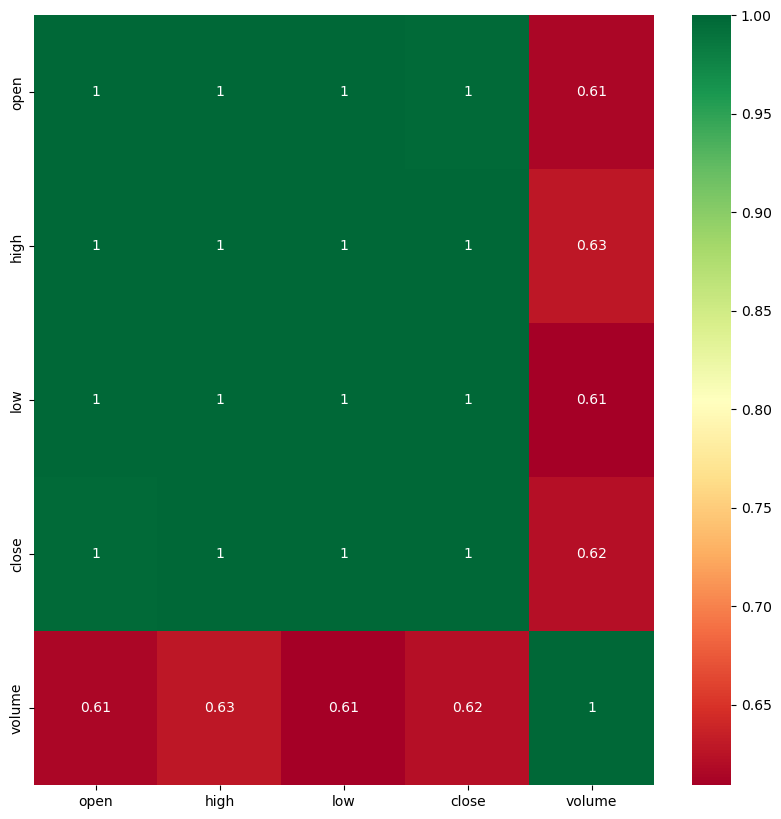

In [78]:
#get correlations of each features in dataset
df = STB.drop('date', axis=1)
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(STB[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Preprocessing Data¶

In [79]:
STB.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [80]:
STB.isna().any()

date      False
open      False
high      False
low       False
close     False
volume    False
dtype: bool

In [81]:
# STB.dropna(inplace=True)
# STB.isna().any()
# no need because STB dont have any value null or not a number

# Checking datatype of each column¶


In [82]:
# Checking Data type of each column
print("Date column data type: ", type(STB['date'][0]))
print("Open column data type: ", type(STB['open'][0]))
print("Close column data type: ", type(STB['close'][0]))
print("High column data type: ", type(STB['high'][0]))
print("Low column data type: ", type(STB['low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.int64'>
Close column data type:  <class 'numpy.int64'>
High column data type:  <class 'numpy.int64'>
Low column data type:  <class 'numpy.int64'>


# Convert date from string to date format


In [83]:
# convert date field from string to Date format and make it index
STB['date'] = pd.to_datetime(STB.date)
STB.head()

,date,open,high,low,close,volume
0,2016-01-04,12700,12800,12300,12600,1127820
1,2016-01-05,12600,12600,12300,12300,332490
2,2016-01-06,12400,12900,12400,12800,1267100
3,2016-01-07,12700,12800,12400,12600,835460
4,2016-01-08,12600,12700,12300,12600,452540


. Sorting dataset by date format¶


In [84]:
STB.sort_values(by='date', inplace=True)
STB

,date,open,high,low,close,volume
0,2016-01-04,12700,12800,12300,12600,1127820
1,2016-01-05,12600,12600,12300,12300,332490
2,2016-01-06,12400,12900,12400,12800,1267100
3,2016-01-07,12700,12800,12400,12600,835460
4,2016-01-08,12600,12700,12300,12600,452540
...,...,...,...,...,...,...
1722,2022-11-21,17300,17400,16700,16700,17502900
1723,2022-11-22,16600,17800,16600,16900,30775500
1724,2022-11-23,16900,17900,16900,17500,25665600
1725,2022-11-24,17300,18200,16900,18200,18314400


In [85]:
STB.shape

(1727, 6)

# EDA - Exploratory Data Analysis



Get the duration of dataset


In [86]:
print("Starting date: ",STB.iloc[0][0])
print("Ending date: ", STB.iloc[-1][0])
print("Duration: ", STB.iloc[-1][0]-STB.iloc[0][0])

Starting date:  2016-01-04 00:00:00
Ending date:  2022-11-25 00:00:00
Duration:  2517 days 00:00:00


Monthwise comparision between Stock actual, open and close price


In [87]:
monthvise= STB.groupby(STB['date'].dt.strftime('%B'))[['open','close']].mean().sort_values(by='close')
monthvise

,open,close
date,,
October,14492.091503,14427.516340
November,14509.731544,14521.275168
December,14871.374046,14887.633588
September,15014.680851,14989.716312
May,15299.310345,15331.241379
July,15589.215686,15573.006536
August,15696.178344,15670.382166
January,15799.197080,15852.408759
February,15860.258621,15870.000000


In [88]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock actual, open and close price')
fig.show()

Monthwise High and Low stock price


In [89]:
STB.groupby(STB['date'].dt.strftime('%B'))['low'].min()


date
April         7200
August       10000
December      7360
February      9760
January       8200
July          9670
June         10350
March         7120
May           8930
November      7380
October       8760
September     9300
Name: low, dtype: int64

In [90]:
monthvise_high= STB.groupby(STB['date'].dt.strftime('%B'))['high'].max()
monthvise_low= STB.groupby(STB['date'].dt.strftime('%B'))['low'].min()

In [91]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

Trend comparision between stock price, open price, close price, high price, low price¶


In [92]:
from itertools import cycle
import plotly.express as px

names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(STB, x=STB.date, y=[STB['open'], STB['close'], 
                                          STB['high'], STB['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Close price prediction preparation and preprocessing¶



Make separate dataframe with close price


In [93]:
closedf = STB[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1727, 2)


Plotting stock close price chart


In [94]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Normalizing / scaling close value between 0 to 1


In [95]:
close_stock = closedf.copy()
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1727, 1)


Split data for training and testing


In [96]:
training_size=int(len(closedf)*0.8)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1381, 1)
test_data:  (346, 1)


Create new dataset according to requirement of time-series prediction


In [97]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [98]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 20
print(type(train_data))
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(type(X_test))
print("X_train: ", X_train)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
X_train:  [[0.18563923 0.17513135 0.19264448 ... 0.13660245 0.14010508 0.14010508]
 [0.17513135 0.19264448 0.18563923 ... 0.14010508 0.14010508 0.13660245]
 [0.19264448 0.18563923 0.18563923 ... 0.14010508 0.13660245 0.13309982]
 ...
 [0.78108581 0.75656743 0.81260946 ... 0.84763573 0.88616462 0.80735552]
 [0.75656743 0.81260946 0.82311734 ... 0.88616462 0.80735552 0.83187391]
 [0.81260946 0.82311734 0.79859895 ... 0.80735552 0.83187391 0.80210158]]
y_train:  (1360,)
X_test:  (325, 20)
y_test (325,)


# RF

In [99]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100,random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [100]:
# Lets Do the prediction 

RF_train_predict=regressor.predict(X_train)
RF_test_predict=regressor.predict(X_test)
# print("Train data prediction:", train_predict)
# # print("Test data prediction:", test_predict)
RF_train_predict = RF_train_predict.reshape(-1,1)
RF_test_predict = RF_test_predict.reshape(-1,1)

print("Train data prediction:", RF_train_predict.shape)
print("Test data prediction:", RF_test_predict.shape)

Train data prediction: (1360, 1)
Test data prediction: (325, 1)


In [101]:
# Transform back to original form

RF_train_predict = scaler.inverse_transform(RF_train_predict)
RF_test_predict = scaler.inverse_transform(RF_test_predict)
RF_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
RF_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [102]:
# Evaluation metrices RMSE and MAE
RF_RMSE_train = math.sqrt(mean_squared_error(RF_original_ytrain,RF_train_predict))
RF_MSE_train = mean_squared_error(RF_original_ytrain,RF_train_predict)
RF_MAE_train = mean_absolute_error(RF_original_ytrain,RF_train_predict)

RF_RMSE_test = math.sqrt(mean_squared_error(RF_original_ytest,RF_test_predict))
RF_MSE_test = mean_squared_error(RF_original_ytest,RF_test_predict)
RF_MAE_test = mean_absolute_error(RF_original_ytest,RF_test_predict)

print("Train data RMSE: ", RF_RMSE_train)
print("Train data MSE: ", RF_MSE_train)
print("Test data MAE: ", RF_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", RF_RMSE_test)
print("Test data MSE: ", RF_MSE_test)
print("Test data MAE: ", RF_MAE_test)

Train data RMSE:  140.44109231903835
Train data MSE:  19723.700411764654
Test data MAE:  90.06764705882361
-------------------------------------------------------------------------------------
Test data RMSE:  2261.406525560179
Test data MSE:  5113959.473846161
Test data MAE:  1843.0061538461553


Explained variance regression score
The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [103]:
RF_EV_train = explained_variance_score(RF_original_ytrain, RF_train_predict)
RF_EV_test = explained_variance_score(RF_original_ytest, RF_test_predict)

print("Train data explained variance regression score:", RF_EV_train)
print("Test data explained variance regression score:", RF_EV_test)

Train data explained variance regression score: 0.9988410489978278
Test data explained variance regression score: 0.8337027839245372


R2 score for regression
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best
0 or < 0 = worse

In [104]:
RF_r2_train = r2_score(RF_original_ytrain, RF_train_predict)
RF_r2_test = r2_score(RF_original_ytest, RF_test_predict)

print("Train data R2 score:", RF_r2_train)
print("Test data R2 score:", RF_r2_test)

Train data R2 score: 0.9988410246076762
Test data R2 score: 0.8104385103974434


Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)¶


In [105]:
RF_MGD_train = mean_gamma_deviance(RF_original_ytrain, RF_train_predict)
RF_MGD_test = mean_gamma_deviance(RF_original_ytest, RF_test_predict)
RF_MPD_train = mean_poisson_deviance(RF_original_ytrain, RF_train_predict)
RF_MPD_test = mean_poisson_deviance(RF_original_ytest, RF_test_predict)
print("Train data MGD: ", RF_MGD_train)
print("Test data MGD: ", RF_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", RF_MPD_train)
print("Test data MPD: ",RF_MPD_test)

Train data MGD:  9.270863196951937e-05
Test data MGD:  0.006949935161486337
----------------------------------------------------------------------
Train data MPD:  1.2647151207219354
Test data MPD:  186.75692995867698


Comparision between original stock close price vs predicted close price¶


In [106]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(RF_train_predict)+look_back, :] = RF_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(RF_train_predict)+(look_back*2)+1:len(closedf)-1, :] = RF_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1727, 1)
Test predicted data:  (1727, 1)


# Predicting next 10 days


In [107]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = regressor.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = regressor.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


Plotting last 15 days and next predicted 10 days


In [108]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [109]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Plotting whole closing stock price with prediction¶


In [110]:
rfdf=closedf.tolist()
rfdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
rfdf=scaler.inverse_transform(rfdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rfdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# RF + Optuna

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import optuna

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'])
    random_state = 42

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        random_state=random_state
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Use Optuna to optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Optuna: ", best_params)

regressor_optuna = RandomForestRegressor(**best_params)
regressor_optuna.fit(X_train, y_train)

[I 2023-04-23 10:39:52,430] A new study created in memory with name: no-name-8d9daa78-246a-49ce-9cfb-5c783e257343
[I 2023-04-23 10:39:52,513] Trial 0 finished with value: 0.008291966997824788 and parameters: {'n_estimators': 31, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.008291966997824788.
[I 2023-04-23 10:39:52,974] Trial 1 finished with value: 0.007083408118475891 and parameters: {'n_estimators': 139, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'friedman_mse'}. Best is trial 1 with value: 0.007083408118475891.
[W 2023-04-23 10:39:53,032] Trial 2 failed with parameters: {'n_estimators': 214, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'absolute_error'} because of the following error: KeyError('absolute_error').


KeyError: 'absolute_error'

In [ ]:
# Lets Do the prediction 

OP_train_predict=regressor_optuna.predict(X_train)
OP_test_predict=regressor_optuna.predict(X_test)

OP_train_predict = OP_train_predict.reshape(-1,1)
OP_test_predict = OP_test_predict.reshape(-1,1)

print("Train data prediction:", OP_train_predict.shape)
print("Test data prediction:", OP_test_predict.shape)

Train data prediction: (408, 1)
Test data prediction: (87, 1)


In [ ]:
# Transform back to original form

OP_train_predict = scaler.inverse_transform(OP_train_predict)
OP_test_predict = scaler.inverse_transform(OP_test_predict)
OP_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
OP_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
OP_RMSE_train = math.sqrt(mean_squared_error(OP_original_ytrain,OP_train_predict))
OP_MSE_train = mean_squared_error(OP_original_ytrain,RF_train_predict)
OP_MAE_train = mean_absolute_error(OP_original_ytrain,OP_train_predict)
OP_RMSE_test = math.sqrt(mean_squared_error(RF_original_ytest,OP_test_predict))
OP_MSE_test = mean_squared_error(OP_original_ytest,OP_test_predict)
OP_MAE_test = mean_absolute_error(OP_original_ytest,OP_test_predict)

print("Train data RMSE: ", OP_RMSE_train)
print("Train data MSE: ", OP_MSE_train)
print("Test data MAE: ", OP_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", OP_RMSE_test)
print("Test data MSE: ", OP_MSE_test)
print("Test data MAE: ", OP_MAE_test)

Train data RMSE:  621.9537352346334
Train data MSE:  87420.3541666671
Test data MAE:  469.3477805946453
-------------------------------------------------------------------------------------
Test data RMSE:  688.3731191456562
Test data MSE:  473857.5511623199
Test data MAE:  500.27487760436355


In [ ]:
OP_EV_train = explained_variance_score(OP_original_ytrain, OP_train_predict)
OP_EV_test = explained_variance_score(OP_original_ytest, OP_test_predict)

print("Train data explained variance regression score:", OP_EV_train)
print("Test data explained variance regression score:", OP_EV_test)

Train data explained variance regression score: 0.9887708836107307
Test data explained variance regression score: 0.9713768299602057


In [ ]:
OP_r2_train = r2_score(OP_original_ytrain, OP_train_predict)
OP_r2_test = r2_score(OP_original_ytest, OP_test_predict)

print("Train data R2 score:", OP_r2_train)
print("Test data R2 score:", OP_r2_test)

Train data R2 score: 0.9887672857430226
Test data R2 score: 0.9673396459735804


In [ ]:
OP_MGD_train = mean_gamma_deviance(OP_original_ytrain, OP_train_predict)
OP_MGD_test = mean_gamma_deviance(OP_original_ytest, OP_test_predict)
OP_MPD_train = mean_poisson_deviance(OP_original_ytrain, OP_train_predict)
OP_MPD_test = mean_poisson_deviance(OP_original_ytest, OP_test_predict)
print("Train data MGD: ", OP_MGD_train)
print("Test data MGD: ", OP_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", OP_MPD_train)
print("Test data MPD: ",OP_MPD_test)

Train data MGD:  0.0006325760246311622
Test data MGD:  0.0014627588645502565
----------------------------------------------------------------------
Train data MPD:  15.194318107992723
Test data MPD:  26.064993894636025


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(OP_train_predict)+look_back, :] = OP_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(OP_train_predict)+(look_back*2)+1:len(closedf)-1, :] = OP_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (537, 1)
Test predicted data:  (537, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = regressor_optuna.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = regressor_optuna.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
opdf=closedf.tolist()
opdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
opdf=scaler.inverse_transform(opdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rfdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# RF Bayes Optimization

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer

# # Load the stock price data
# df = pd.read_csv('stock_price_data.csv')

# # Split the data into features and target variable
# X = df.drop('target', axis=1)
# y = df['target']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function to minimize
def objective(params):
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = params
    clf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 max_features=max_features, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Define the search space for hyperparameters
space = [Integer(10, 1000, name='n_estimators'),
         Integer(1, 50, name='max_depth'),
         Integer(2, 20, name='min_samples_split'),
         Integer(1, 20, name='min_samples_leaf'),
         Real(0.1, 1.0, prior='uniform', name='max_features')]

# Run Bayesian optimization to find the best hyperparameters
result = gp_minimize(objective, space, n_calls=50, random_state=42)

# Print the best hyperparameters and corresponding mean squared error
print("Best hyperparameters:", result.x)
print("Best mean squared error:", result.fun)

# Train a new random forest regressor with the best hyperparameters
clf = RandomForestRegressor(n_estimators=result.x[0], max_depth=result.x[1],
                             min_samples_split=result.x[2], min_samples_leaf=result.x[3],
                             max_features=result.x[4], random_state=42)
clf.fit(X_train, y_train)

# # Use the trained model to predict future stock prices
# future_dates = pd.date_range(start='2023-04-14', end='2024-04-14', freq='D')
# future_X = pd.DataFrame({'date': future_dates})
# future_X['day_of_week'] = future_X['date'].dt.dayofweek
# future_X['month'] = future_X['date'].dt.month
# future_X['day_of_month'] = future_X['date'].dt.day
# future_X['year'] = future_X['date'].dt.year
# future_X = future_X.drop('date', axis=1)
# future_y = clf.predict(future_X)


Best hyperparameters: [282, 50, 7, 10, 1.0]
Best mean squared error: 0.0009429529213878074


RandomForestRegressor(max_depth=50, min_samples_leaf=10, min_samples_split=7,
                      n_estimators=282, random_state=42)

In [ ]:
# Lets Do the prediction 

BY_train_predict=clf.predict(X_train)
BY_test_predict=clf.predict(X_test)
# print("Train data prediction:", train_predict)
# # print("Test data prediction:", test_predict)
BY_train_predict = BY_train_predict.reshape(-1,1)
BY_test_predict = BY_test_predict.reshape(-1,1)

print("Train data prediction:", RF_train_predict.shape)
print("Test data prediction:", RF_test_predict.shape)

Train data prediction: (408, 1)
Test data prediction: (87, 1)


In [ ]:
# Transform back to original form

BY_train_predict = scaler.inverse_transform(BY_train_predict)
BY_test_predict = scaler.inverse_transform(BY_test_predict)
BY_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
BY_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
BY_RMSE_train = math.sqrt(mean_squared_error(BY_original_ytrain,BY_train_predict))
BY_MSE_train = mean_squared_error(BY_original_ytrain,BY_train_predict)
BY_MAE_train = mean_absolute_error(BY_original_ytrain,BY_train_predict)

BY_RMSE_test = math.sqrt(mean_squared_error(BY_original_ytest,BY_test_predict))
BY_MSE_test = mean_squared_error(BY_original_ytest,BY_test_predict)
BY_MAE_test = mean_absolute_error(BY_original_ytest,BY_test_predict)

print("Train data RMSE: ", BY_RMSE_train)
print("Train data MSE: ", BY_MSE_train)
print("Test data MAE: ", BY_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", BY_RMSE_test)
print("Test data MSE: ", BY_MSE_test)
print("Test data MAE: ", BY_MAE_test)

Train data RMSE:  631.6870629287992
Train data MSE:  399028.5454716127
Test data MAE:  475.6699954392562
-------------------------------------------------------------------------------------
Test data RMSE:  698.5965011190486
Test data MSE:  488037.0713757769
Test data MAE:  512.1551195524803


In [ ]:
BY_EV_train = explained_variance_score(BY_original_ytrain, BY_train_predict)
BY_EV_test = explained_variance_score(BY_original_ytest, BY_test_predict)

print("Train data explained variance regression score:", BY_EV_train)
print("Test data explained variance regression score:", BY_EV_test)

Train data explained variance regression score: 0.9884129623398789
Test data explained variance regression score: 0.9706252068082283


In [ ]:
BY_r2_train = r2_score(BY_original_ytrain, BY_train_predict)
BY_r2_test = r2_score(BY_original_ytest, BY_test_predict)

print("Train data R2 score:", BY_r2_train)
print("Test data R2 score:", BY_r2_test)

Train data R2 score: 0.988412959750076
Test data R2 score: 0.9663623308522737


In [ ]:
BY_MGD_train = mean_gamma_deviance(BY_original_ytrain, BY_train_predict)
BY_MGD_test = mean_gamma_deviance(BY_original_ytest, BY_test_predict)
BY_MPD_train = mean_poisson_deviance(BY_original_ytrain, BY_train_predict)
BY_MPD_test = mean_poisson_deviance(BY_original_ytest, BY_test_predict)
print("Train data MGD: ", BY_MGD_train)
print("Test data MGD: ", BY_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", BY_MPD_train)
print("Test data MPD: ",BY_MPD_test)

Train data MGD:  0.0006409286168552588
Test data MGD:  0.0015054859992264824
----------------------------------------------------------------------
Train data MPD:  15.54194775978938
Test data MPD:  26.826734157042374


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(BY_train_predict)+look_back, :] = BY_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(RF_train_predict)+(look_back*2)+1:len(closedf)-1, :] = RF_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (537, 1)
Test predicted data:  (537, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = clf.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = clf.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
bydf=closedf.tolist()
bydf.extend((np.array(lst_output).reshape(-1,1)).tolist())
bydf=scaler.inverse_transform(bydf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(bydf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# RandomizedSearchCV + RF 

In [ ]:
regressor1 = RandomForestRegressor(random_state = 0)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rfc_cv = RandomizedSearchCV(estimator = regressor1,  param_distributions = params_grid, verbose = 0, cv = 5, n_iter = 100,n_jobs=-1)

In [ ]:
rfc_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]})

In [ ]:
print(f'best: {rfc_cv.best_params_}')


best: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


In [ ]:
regressor1 = RandomForestRegressor(**rfc_cv.best_params_)

In [ ]:
regressor1.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, max_features='auto', min_samples_leaf=4,
                      n_estimators=800)

In [ ]:
# Lets Do the prediction 

rf_cv_train_predict=regressor1.predict(X_train)
rf_cv_test_predict=regressor1.predict(X_test)
# print("Train data prediction:", train_predict)
# # print("Test data prediction:", test_predict)
rf_cv_train_predict = rf_cv_train_predict.reshape(-1,1)
rf_cv_test_predict = rf_cv_test_predict.reshape(-1,1)

print("Train data prediction:", rf_cv_train_predict.shape)
print("Test data prediction:", rf_cv_test_predict.shape)

Train data prediction: (408, 1)
Test data prediction: (87, 1)


In [ ]:
# Transform back to original form

rf_cv_train_predict = scaler.inverse_transform(rf_cv_train_predict)
rf_cv_test_predict = scaler.inverse_transform(rf_cv_test_predict)
rf_cv_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
rf_cv_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
rf_cv_RMSE_train = math.sqrt(mean_squared_error(rf_cv_original_ytrain,rf_cv_train_predict))
rf_cv_MSE_train = mean_squared_error(rf_cv_original_ytrain,rf_cv_train_predict)
rf_cv_MAE_train = mean_absolute_error(rf_cv_original_ytrain,rf_cv_train_predict)

rf_cv_RMSE_test = math.sqrt(mean_squared_error(rf_cv_original_ytest,rf_cv_test_predict))
rf_cv_MSE_test = mean_squared_error(rf_cv_original_ytest,rf_cv_test_predict)
rf_cv_MAE_test = mean_absolute_error(rf_cv_original_ytest,rf_cv_test_predict)

print("Train data RMSE: ", math.sqrt(mean_squared_error(rf_cv_original_ytrain,rf_cv_train_predict)))
print("Train data MSE: ", mean_squared_error(rf_cv_original_ytrain,rf_cv_train_predict))
print("Test data MAE: ", mean_absolute_error(rf_cv_original_ytrain,rf_cv_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(rf_cv_original_ytest,rf_cv_test_predict)))
print("Test data MSE: ", mean_squared_error(rf_cv_original_ytest,rf_cv_test_predict))
print("Test data MAE: ", mean_absolute_error(rf_cv_original_ytest,rf_cv_test_predict))

Train data RMSE:  475.20479766882727
Train data MSE:  225819.59972747104
Test data MAE:  339.94428687777474
-------------------------------------------------------------------------------------
Test data RMSE:  726.1843685368799
Test data MSE:  527343.7371073071
Test data MAE:  537.8459555187957


In [ ]:
rf_cv_EV_train = explained_variance_score(rf_cv_original_ytrain, rf_cv_train_predict)
rf_cv_EV_test = explained_variance_score(rf_cv_original_ytest, rf_cv_test_predict)

print("Train data explained variance regression score:", explained_variance_score(rf_cv_original_ytrain, rf_cv_train_predict))
print("Test data explained variance regression score:", explained_variance_score(rf_cv_original_ytest, rf_cv_test_predict))

Train data explained variance regression score: 0.9934435809998916
Test data explained variance regression score: 0.9691227263332228


In [ ]:
rf_cv_r2_train = r2_score(rf_cv_original_ytrain, rf_cv_train_predict)
rf_cv_r2_test = r2_score(rf_cv_original_ytest, rf_cv_test_predict)

print("Train data R2 score:", r2_score(rf_cv_original_ytrain, rf_cv_train_predict))
print("Test data R2 score:", r2_score(rf_cv_original_ytest, rf_cv_test_predict))

Train data R2 score: 0.9934426225367626
Test data R2 score: 0.9636531419510079


In [ ]:
rf_cv_MGD_train = mean_gamma_deviance(rf_cv_original_ytrain, rf_cv_train_predict)
rf_cv_MGD_test = mean_gamma_deviance(rf_cv_original_ytest, rf_cv_test_predict)
rf_cv_MPD_train = mean_poisson_deviance(rf_cv_original_ytrain, rf_cv_train_predict)
rf_cv_MPD_test = mean_poisson_deviance(rf_cv_original_ytest, rf_cv_test_predict)

print("Train data MGD: ", mean_gamma_deviance(rf_cv_original_ytrain, rf_cv_train_predict))
print("Test data MGD: ", mean_gamma_deviance(rf_cv_original_ytest, rf_cv_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(rf_cv_original_ytrain, rf_cv_train_predict))
print("Test data MPD: ", mean_poisson_deviance(rf_cv_original_ytest, rf_cv_test_predict))

Train data MGD:  0.00035875206395044113
Test data MGD:  0.00158953771980887
----------------------------------------------------------------------
Train data MPD:  8.790577784256156
Test data MPD:  28.642421718752846


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(rf_cv_train_predict)+look_back, :] = rf_cv_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(rf_cv_train_predict)+(look_back*2)+1:len(closedf)-1, :] = rf_cv_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (537, 1)
Test predicted data:  (537, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = regressor1.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = regressor1.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
rf_cvdf=closedf.tolist()
rf_cvdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
rf_cvdf=scaler.inverse_transform(rf_cvdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rf_cvdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# Extra Tree (Random Forest extension)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor


In [ ]:
et = ExtraTreesRegressor(n_estimators = 100, min_samples_split = 10, min_samples_leaf = 4, max_features = 'auto', max_depth = 60, bootstrap = True, random_state = 0)


In [ ]:
et.fit(X_train, y_train)


ExtraTreesRegressor(bootstrap=True, max_depth=60, max_features='auto',
                    min_samples_leaf=4, min_samples_split=10, random_state=0)

In [ ]:
# Lets Do the prediction 

et_train_predict=et.predict(X_train)
et_test_predict=et.predict(X_test)
# print("Train data prediction:", train_predict)
# # print("Test data prediction:", test_predict)
et_train_predict = et_train_predict.reshape(-1,1)
et_test_predict = et_test_predict.reshape(-1,1)

print("Train data prediction:", et_train_predict.shape)
print("Test data prediction:", et_test_predict.shape)

Train data prediction: (408, 1)
Test data prediction: (87, 1)


In [ ]:
# Transform back to original form

et_train_predict = scaler.inverse_transform(et_train_predict)
et_test_predict = scaler.inverse_transform(et_test_predict)
et_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
et_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
et_RMSE_train = math.sqrt(mean_squared_error(et_original_ytrain,et_train_predict))
et_MSE_train = mean_squared_error(et_original_ytrain,et_train_predict)
et_MAE_train = mean_absolute_error(et_original_ytrain,et_train_predict)

et_RMSE_test = math.sqrt(mean_squared_error(et_original_ytest,et_test_predict))
et_MSE_test = mean_squared_error(et_original_ytest,et_test_predict)
et_MAE_test = mean_absolute_error(et_original_ytest,et_test_predict)

print("Train data RMSE: ", math.sqrt(mean_squared_error(et_original_ytrain,et_train_predict)))
print("Train data MSE: ", mean_squared_error(et_original_ytrain,et_train_predict))
print("Test data MAE: ", mean_absolute_error(et_original_ytrain,et_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(et_original_ytest,et_test_predict)))
print("Test data MSE: ", mean_squared_error(et_original_ytest,et_test_predict))
print("Test data MAE: ", mean_absolute_error(et_original_ytest,et_test_predict))

Train data RMSE:  631.8109964283034
Train data MSE:  399185.13520772563
Test data MAE:  459.3569002877423
-------------------------------------------------------------------------------------
Test data RMSE:  924.2408564437072
Test data MSE:  854221.1607197975
Test data MAE:  689.4292900489215


In [ ]:
et_EV_train = explained_variance_score(et_original_ytrain, et_train_predict)
et_EV_test = explained_variance_score(et_original_ytest, et_test_predict)

print("Train data explained variance regression score:", explained_variance_score(et_original_ytrain, et_train_predict))
print("Test data explained variance regression score:", explained_variance_score(et_original_ytest,et_test_predict))

Train data explained variance regression score: 0.988408549002886
Test data explained variance regression score: 0.9594697737858665


In [ ]:
et_r2_train = r2_score(et_original_ytrain, et_train_predict)
et_r2_test = r2_score(et_original_ytest, et_test_predict)

print("Train data R2 score:", r2_score(et_original_ytrain, et_train_predict))
print("Test data R2 score:", r2_score(et_original_ytest, et_test_predict))

Train data R2 score: 0.9884084126779539
Test data R2 score: 0.9411233070834597


In [ ]:
et_MGD_train = mean_gamma_deviance(et_original_ytrain, et_train_predict)
et_MGD_test = mean_gamma_deviance(et_original_ytest, et_test_predict)
et_MPD_train = mean_poisson_deviance(et_original_ytrain, et_train_predict)
et_MPD_test = mean_poisson_deviance(et_original_ytest, et_test_predict)

print("Train data MGD: ", mean_gamma_deviance(et_original_ytrain, et_train_predict))
print("Test data MGD: ", mean_gamma_deviance(et_original_ytest, et_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(et_original_ytrain, et_train_predict))
print("Test data MPD: ", mean_poisson_deviance(et_original_ytest, et_test_predict))

Train data MGD:  0.0006298332452267236
Test data MGD:  0.0026448824886272405
----------------------------------------------------------------------
Train data MPD:  15.48425812897818
Test data MPD:  47.14245796583602


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(et_train_predict)+look_back, :] = et_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(et_train_predict)+(look_back*2)+1:len(closedf)-1, :] = et_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (537, 1)
Test predicted data:  (537, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = et.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = et.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
etdf=closedf.tolist()
etdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
etdf=scaler.inverse_transform(etdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(etdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# KNN 

In [ ]:
from sklearn import neighbors

K = time_step
neighbor = neighbors.KNeighborsRegressor(n_neighbors = 5)
neighbor.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
# Lets Do the prediction 

KNN_train_predict=neighbor.predict(X_train)
KNN_test_predict=neighbor.predict(X_test)

KNN_train_predict = KNN_train_predict.reshape(-1,1)
KNN_test_predict = KNN_test_predict.reshape(-1,1)

print("Train data prediction:", KNN_train_predict.shape)
print("Test data prediction:", KNN_test_predict.shape)

Train data prediction: (408, 1)
Test data prediction: (87, 1)


In [ ]:
# Transform back to original form

KNN_train_predict = scaler.inverse_transform(KNN_train_predict)
KNN_test_predict = scaler.inverse_transform(KNN_test_predict)
KNN_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
KNN_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [ ]:
# Evaluation metrices RMSE and MAE
KNN_RMSE_train = math.sqrt(mean_squared_error(KNN_original_ytrain,KNN_train_predict))
KNN_MSE_train = mean_squared_error(KNN_original_ytrain,KNN_train_predict)
KNN_MAE_train = mean_absolute_error(KNN_original_ytrain,KNN_train_predict)

KNN_RMSE_test = math.sqrt(mean_squared_error(KNN_original_ytest,KNN_test_predict))
KNN_MSE_test = mean_squared_error(KNN_original_ytest,KNN_test_predict)
KNN_MAE_test = mean_absolute_error(KNN_original_ytest,KNN_test_predict)

print("Train data RMSE: ", KNN_RMSE_train)
print("Train data MSE: ", KNN_MSE_train)
print("Test data MAE: ", KNN_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", KNN_RMSE_test)
print("Test data MSE: ", KNN_MSE_test)
print("Test data MAE: ", KNN_MAE_test)

Train data RMSE:  586.5422940803995
Train data MSE:  344031.8627450979
Test data MAE:  432.20588235294105
-------------------------------------------------------------------------------------
Test data RMSE:  2032.5260315591327
Test data MSE:  4131162.068965516
Test data MAE:  1714.597701149425


Explained variance regression score
The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [ ]:
KNN_EV_train = explained_variance_score(KNN_original_ytrain, KNN_train_predict)
KNN_EV_test = explained_variance_score(KNN_original_ytest, KNN_test_predict)

print("Train data explained variance regression score:", KNN_EV_train)
print("Test data explained variance regression score:", KNN_EV_test)

Train data explained variance regression score: 0.9900100457003659
Test data explained variance regression score: 0.8905190657641263


R2 score for regression
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best
0 or < 0 = worse

In [ ]:
KNN_r2_train = r2_score(KNN_original_ytrain, KNN_train_predict)
KNN_r2_test = r2_score(KNN_original_ytest, KNN_test_predict)

print("Train data R2 score:", KNN_r2_train)
print("Test data R2 score:", KNN_r2_test)

Train data R2 score: 0.9900099602243435
Test data R2 score: 0.7152620753178387


# Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)¶


In [ ]:
KNN_MGD_train = mean_gamma_deviance(KNN_original_ytrain, KNN_train_predict)
KNN_MGD_test = mean_gamma_deviance(KNN_original_ytest, KNN_test_predict)
KNN_MPD_train = mean_poisson_deviance(KNN_original_ytrain, KNN_train_predict)
KNN_MPD_test = mean_poisson_deviance(KNN_original_ytest, KNN_test_predict)
print("Train data MGD: ", KNN_MGD_train)
print("Test data MGD: ", KNN_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", KNN_MPD_train)
print("Test data MPD: ",KNN_MPD_test)

Train data MGD:  0.0005295745423309808
Test data MGD:  0.00936349786564034
----------------------------------------------------------------------
Train data MPD:  13.188419242315163
Test data MPD:  193.68345197269267


Comparision between original stock close price vs predicted close price


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(KNN_train_predict)+look_back, :] = KNN_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(KNN_train_predict)+(look_back*2)+1:len(closedf)-1, :] = KNN_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (537, 1)
Test predicted data:  (537, 1)


Predicting next 10 days¶


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = neighbor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = neighbor.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


Plotting last 15 days and next predicted 10 days¶


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Plotting whole closing stock price with prediction


In [ ]:
knndf=closedf.tolist()
knndf.extend((np.array(lst_output).reshape(-1,1)).tolist())
knndf=scaler.inverse_transform(knndf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(knndf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# finaldf = pd.DataFrame({
#     'rf':rfdf,
#     'knn':knndf,
#     'rf_cv':rf_cvdf,
#     'et': etdf,
# })
# finaldf.tail()

In [ ]:
# names = cycle([ 'RF','KNN','RF_CV','ET'])

# fig = px.line(finaldf[225:], x=finaldf.index[225:], y=[finaldf['rf'][225:], finaldf['knn'][225:], finaldf['rf_cv'][225:],finaldf['et'][225:]],
#              labels={'x': 'Timestamp','value':'Stock close price'})
# fig.update_layout(title_text='Final stock analysis chart', font_size=15, font_color='black',legend_title_text='Algorithms')
# fig.for_each_trace(lambda t:  t.update(name = next(names)))
# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)

# fig.show()

In [ ]:
# EM_train = {'Random Forest':["{:.4f}".format(RF_RMSE_train),"{:.4f}".format(RF_MSE_train),"{:.4f}".format(RF_MAE_train),
#                        "{:.4f}".format(RF_EV_train),
#                        "{:.4f}".format(RF_r2_train),
#                        "{:.4f}".format(RF_MGD_train),
#                        "{:.4f}".format(RF_MPD_train)],
#       'KNN':["{:.4f}".format(KNN_RMSE_train),"{:.4f}".format(KNN_MSE_train),"{:.4f}".format(KNN_MAE_train),
#                       "{:.4f}".format(KNN_EV_train),
#                        "{:.4f}".format(KNN_r2_train),
#                        "{:.4f}".format(KNN_MGD_train),
#                        "{:.4f}".format(KNN_MPD_train)],
#             'RF + RandomizedSearchCV':["{:.4f}".format(rf_cv_RMSE_train),"{:.4f}".format(rf_cv_MSE_train),"{:.4f}".format(rf_cv_MAE_train),
#                        "{:.4f}".format(rf_cv_EV_train),
#                        "{:.4f}".format(rf_cv_r2_train),
#                        "{:.4f}".format(rf_cv_MGD_train),
#                        "{:.4f}".format(rf_cv_MPD_train)],
#                  'ET':["{:.4f}".format(et_RMSE_train),"{:.4f}".format(et_MSE_train),"{:.4f}".format(et_MAE_train),
#                       "{:.4f}".format(et_EV_train),
#                        "{:.4f}".format(et_r2_train),
#                        "{:.4f}".format(et_MGD_train),
#                        "{:.4f}".format(et_MPD_train)]}
# EM_test = {'Random Forest':["{:.4f}".format(RF_RMSE_test),"{:.4f}".format(RF_MSE_test),"{:.4f}".format(RF_MAE_test),
#                        "{:.4f}".format(RF_EV_test),
#                        "{:.4f}".format(RF_r2_test),
#                        "{:.4f}".format(RF_MGD_test),
#                        "{:.4f}".format(RF_MPD_test)],
#       'KNN':["{:.4f}".format(KNN_RMSE_test),"{:.4f}".format(KNN_MSE_test),"{:.4f}".format(KNN_MAE_test),
#                       "{:.4f}".format(KNN_EV_test),
#                        "{:.4f}".format(KNN_r2_test),
#                        "{:.4f}".format(KNN_MGD_test),
#                        "{:.4f}".format(KNN_MPD_test)],
#           'RF + RandomizedSearchCV':["{:.4f}".format(rf_cv_RMSE_test),"{:.4f}".format(rf_cv_MSE_test),"{:.4f}".format(rf_cv_MAE_test),
#                        "{:.4f}".format(rf_cv_EV_test),
#                        "{:.4f}".format(rf_cv_r2_test),
#                        "{:.4f}".format(rf_cv_MGD_test),
#                        "{:.4f}".format(rf_cv_MPD_test)],      
#            'ET':["{:.4f}".format(et_RMSE_test),"{:.4f}".format(et_MSE_test),"{:.4f}".format(et_MAE_test),
#                       "{:.4f}".format(et_EV_test),
#                        "{:.4f}".format(et_r2_test),
#                        "{:.4f}".format(et_MGD_test),
#                        "{:.4f}".format(et_MPD_test)]}
# EM_comparision_train = pd.DataFrame(EM_train,index=['RMSE','MSE','MAE','Explained variance regression score','R2 score','MGD','MPD'])
# EM_comparision_test = pd.DataFrame(EM_test,index=['RMSE','MSE','MAE','Explained variance regression score','R2 score','MGD','MPD'])

# print((EM_comparision_train))
# print('--------------------------------------------------------------------------------------------------')
# print(format(EM_comparision_test))